# Predicting Corporate Credit Rating: Model Comparison and Feature Impact

This notebook predicts corporate credit ratings using KNN, Decision Tree, Logistic Regression, and SVM classifiers. We compare their performance and identify features with the highest impact on the rating.

**Overview**: 

### Getting Started

Our dataset comes from Kaggle [corporate-credit-rating-with-financial-ratios](https://www.kaggle.com/datasets/kirtandelwadia/corporate-credit-rating-with-financial-ratios/data).

**Citation**: 
Makwana, R., Bhatt, D., Delwadia, K. et al. Understanding and Attaining an Investment Grade Rating in the Age of Explainable AI. Comput Econ 66, 105–126 (2025). https://doi.org/10.1007/s10614-024-10700-7


## 1. Import Required Libraries

We import pandas, numpy, matplotlib, seaborn, and scikit-learn modules, including classifiers, metrics, preprocessing, and pipeline utilities.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

import time
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Inspect the Data

We load the dataset and inspect its structure, data types, and missing values.

In [2]:
# Load the data
df = pd.read_csv('data/corporateCreditRatingWithFinancialRatios.csv.zip', compression='zip')

print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")

# Display the first few rows
display(df.head())

The dataset has 7805 rows and 25 columns


,Rating Agency,Corporation,Rating,Rating Date,CIK,Binary Rating,SIC Code,Sector,Ticker,Current Ratio,...,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
0,Standard & Poor's Ratings Services,American States Water Co.,A-,2010-07-30,1056903,1,4941.0,Utils,AWR,1.1507,...,28.9834,13.6093,8.3224,0.3173,8.1724,8.1978,2.6385,4.4530,1.9957,-0.1333
1,Standard & Poor's Ratings Services,Automatic Data Processing Inc.,AAA,2010-09-16,8670,1,7374.0,BusEq,ADP,1.1129,...,23.9379,20.8699,13.5690,0.3324,22.0354,47.2858,4.4944,21.8765,0.2501,0.3132
2,Standard & Poor's Ratings Services,Avnet Inc.,BBB-,2010-11-23,8858,1,5065.0,Shops,AVT,1.9276,...,3.6338,3.0536,2.1418,2.4620,13.6376,16.7991,5.2731,9.6494,-7.6079,-7.3231
3,Standard & Poor's Ratings Services,California Water Service Co.,AA-,2010-06-29,1035201,1,4941.0,Utils,CWT,0.8358,...,27.9377,15.1135,9.0246,0.2946,9.6412,9.7015,2.6583,5.1018,1.7438,-0.8999
4,Standard & Poor's Ratings Services,Cardinal Health Inc.,A,2010-07-14,721371,1,5122.0,Shops,CAH,1.2931,...,1.5847,1.2304,0.6518,4.9276,11.1256,19.4184,2.9364,8.1844,1.9725,2.4174


## 3. Dataset Features
- The dataset has 7805 rows and 25 columns
- 16 columns are related to financial ratios

#### Identifiers & Metadata
1. **Rating Agency**: Name of the credit rating agency that issued the rating (e.g., S&P, Moody’s, Fitch).  
2. **Corporation**: Company name (reporting/legal entity).  
3. **Binary Rating**: Simplified label (e.g., Investment Grade vs Non‑Investment Grade). 
4. **Rating Date**: Date when the rating was issued or recorded.  
5. **CIK**: SEC Central Index Key — unique numeric identifier for the company.  
6. **SIC Code**: Standard Industrial Classification code indicating the company’s industry.  
7. **Sector**: High‑level industry sector name (e.g., Finance, Manufacturing).  
8. **Ticker**: Stock market ticker symbol.
#### Financial Ratios
9. **Current Ratio**: Current Assets / Current Liabilities — short‑term liquidity measure.
10. **Long-term Debt / Capital**: Long‑term debt divided by total capital (debt + equity) — long‑term leverage proportion.  
11. **Debt/Equity Ratio**: Total Debt / Total Equity — leverage relative to shareholders’ equity.
12. **Gross Margin**: (Revenue − Cost of Goods Sold) / Revenue — percentage of revenue retained after COGS.  
13. **Operating Margin**: Operating Income / Revenue — core‑operations profitability.  
14.  **EBIT Margin**: EBIT / Revenue — operating profitability before interest and taxes.  
15. **EBITDA Margin**: EBITDA / Revenue — operating profitability excluding depreciation & amortization.  
16. **Pre-Tax Profit Margin**: Pre‑Tax Income / Revenue — profitability before taxes.  
17. **Net Profit Margin**: Net Income / Revenue — overall profitability after all expenses and taxes.
18. **Asset Turnover**: Revenue / Total Assets — how efficiently assets generate sales.  
19. **ROE - Return On Equity**: Net Income / Shareholders’ Equity — return generated on equity.  
20. **Return On Tangible Equity**: Net Income / Tangible Equity — ROE using tangible (net of intangibles) equity.  
21. **ROA - Return On Assets**: Net Income / Total Assets — profitability relative to asset base.  
22. **ROI - Return On Investment**: Return (profit) divided by invested capital — general investment efficiency (dataset definition may vary).
23. **Operating Cash Flow Per Share**: Operating Cash Flow / Shares Outstanding — cash generated from operations per share.  
24. **Free Cash Flow Per Share**: Free Cash Flow / Shares Outstanding — discretionary cash flow (after capex) per share.
25. **Rating**: Credit rating assigned by the agency (e.g., AAA, BBB+, B). — target variable. 

## 4. Exploratory Data Analysis

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7805 entries, 0 to 7804
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Rating Agency                  7805 non-null   object 
 1   Corporation                    7805 non-null   object 
 2   Rating                         7805 non-null   object 
 3   Rating Date                    7805 non-null   object 
 4   CIK                            7805 non-null   int64  
 5   Binary Rating                  7805 non-null   int64  
 6   SIC Code                       7805 non-null   float64
 7   Sector                         7805 non-null   object 
 8   Ticker                         7805 non-null   object 
 9   Current Ratio                  7805 non-null   float64
 10  Long-term Debt / Capital       7805 non-null   float64
 11  Debt/Equity Ratio              7805 non-null   float64
 12  Gross Margin                   7805 non-null   f

### 4.1. Missing Values Analysis

In [4]:
# Check missing values percentage
missing_percent = df.isnull().mean() * 100
print("Missing value percentage per column:\n", missing_percent.sort_values(ascending=False))

print("There are no null values in any Column\n")

# Show unique values in target
print("Unique ratings:", df['Rating'].unique())

Missing value percentage per column:
 Rating Agency                    0.0
Operating Margin                 0.0
Operating Cash Flow Per Share    0.0
ROI - Return On Investment       0.0
ROA - Return On Assets           0.0
Return On Tangible Equity        0.0
ROE - Return On Equity           0.0
Asset Turnover                   0.0
Net Profit Margin                0.0
Pre-Tax Profit Margin            0.0
EBITDA Margin                    0.0
EBIT Margin                      0.0
Gross Margin                     0.0
Corporation                      0.0
Debt/Equity Ratio                0.0
Long-term Debt / Capital         0.0
Current Ratio                    0.0
Ticker                           0.0
Sector                           0.0
SIC Code                         0.0
Binary Rating                    0.0
CIK                              0.0
Rating Date                      0.0
Rating                           0.0
Free Cash Flow Per Share         0.0
dtype: float64
There are no null valu

### 4.2. Summary Statistics

In [5]:
# Calculate descriptive statistics for numerical columns.
# Get numerical columns (excluding  CIK, SIC Code and Binary Rating)
numerical_cols = df.select_dtypes(include=[np.number]).columns.drop(['CIK', 'SIC Code', 'Binary Rating'])

# Calculate descriptive statistics
print("Descriptive Statistics:")
display(df[numerical_cols].describe())
print("Many numerical columns have extreme min and max values, indicating potential outliers.")

Descriptive Statistics:


,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000,7805.000000
mean,1.926313,0.452804,0.177349,42.433909,11.531612,11.582683,20.071493,8.659944,5.995566,0.849843,15.950507,21.481589,4.575705,7.076084,0.479756,0.119491
std,1.921651,2.629158,34.456334,23.742020,25.469044,25.483934,24.380407,27.866408,24.055577,0.696204,230.592526,462.734075,9.229899,24.382027,6.050626,7.253660
min,0.174900,-86.363600,-1473.098000,-87.684000,-461.787800,-461.787800,-360.816900,-476.010000,-414.824800,0.068400,-11258.210000,-14023.260000,-226.442500,-745.454500,-91.330200,-130.665800
25%,1.077300,0.286500,0.419700,22.453900,6.098200,6.181100,11.162100,4.008700,2.637100,0.399500,6.022800,-12.233900,2.391900,3.692600,-0.448500,-0.723700
50%,1.496800,0.427200,0.752800,39.635400,12.120100,12.155800,18.304500,9.705100,6.938900,0.661200,12.500000,10.564100,4.767500,7.440800,0.237800,0.133500
75%,2.161000,0.542200,1.211600,59.641700,19.464600,19.539900,30.661600,16.676900,12.366700,1.038800,20.515700,26.894100,7.881300,12.515100,1.088800,0.997800
max,34.076800,171.500000,194.375000,100.000000,93.993000,93.993000,286.493500,221.289400,219.390300,8.503900,7038.461000,9882.979000,114.716900,466.666700,282.192100,107.737700


Many numerical columns have extreme min and max values, indicating potential outliers.


### 4.3. Data Distribution Analysis

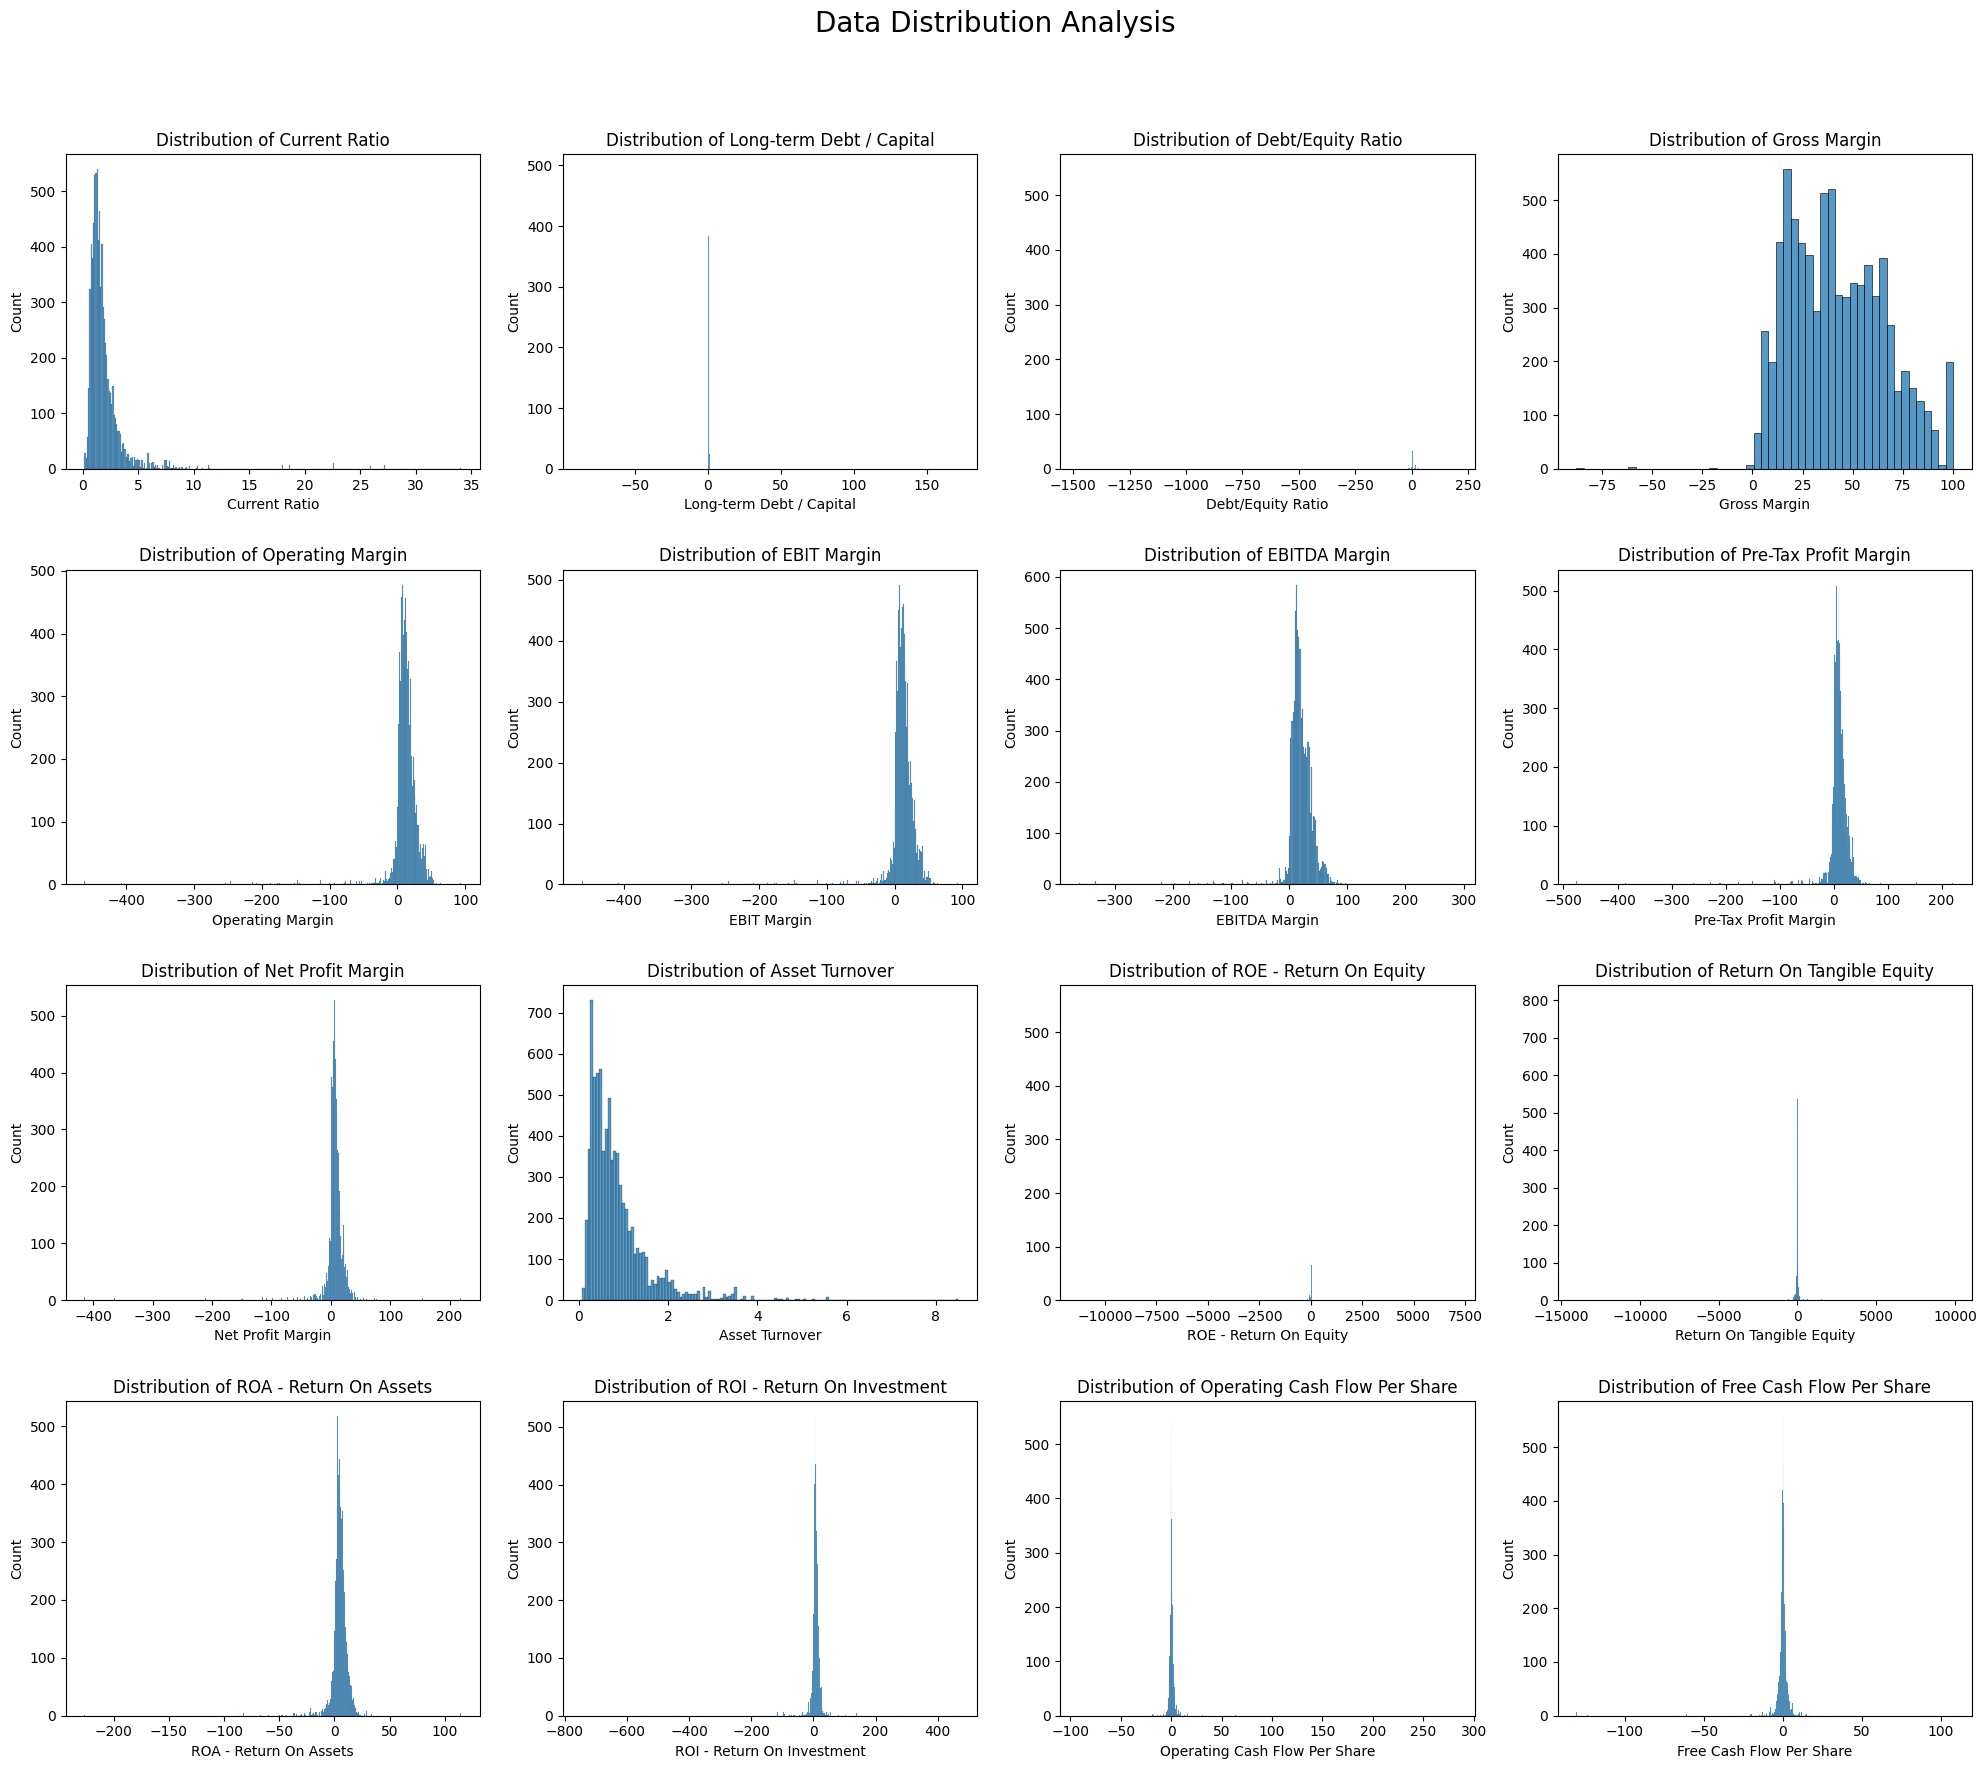

In [6]:
# Data Distribution Analysis
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 18))
axes = axes.flatten()

plt.suptitle('Data Distribution Analysis', fontsize=20)
i=0
for col in numerical_cols:
    # Histogram with KDE
    sns.histplot(df, x=col, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
    i += 1
plt.tight_layout(h_pad=3.0)
plt.subplots_adjust(top=0.9)
plt.savefig('images/data_distribution_analysis.png', bbox_inches='tight')

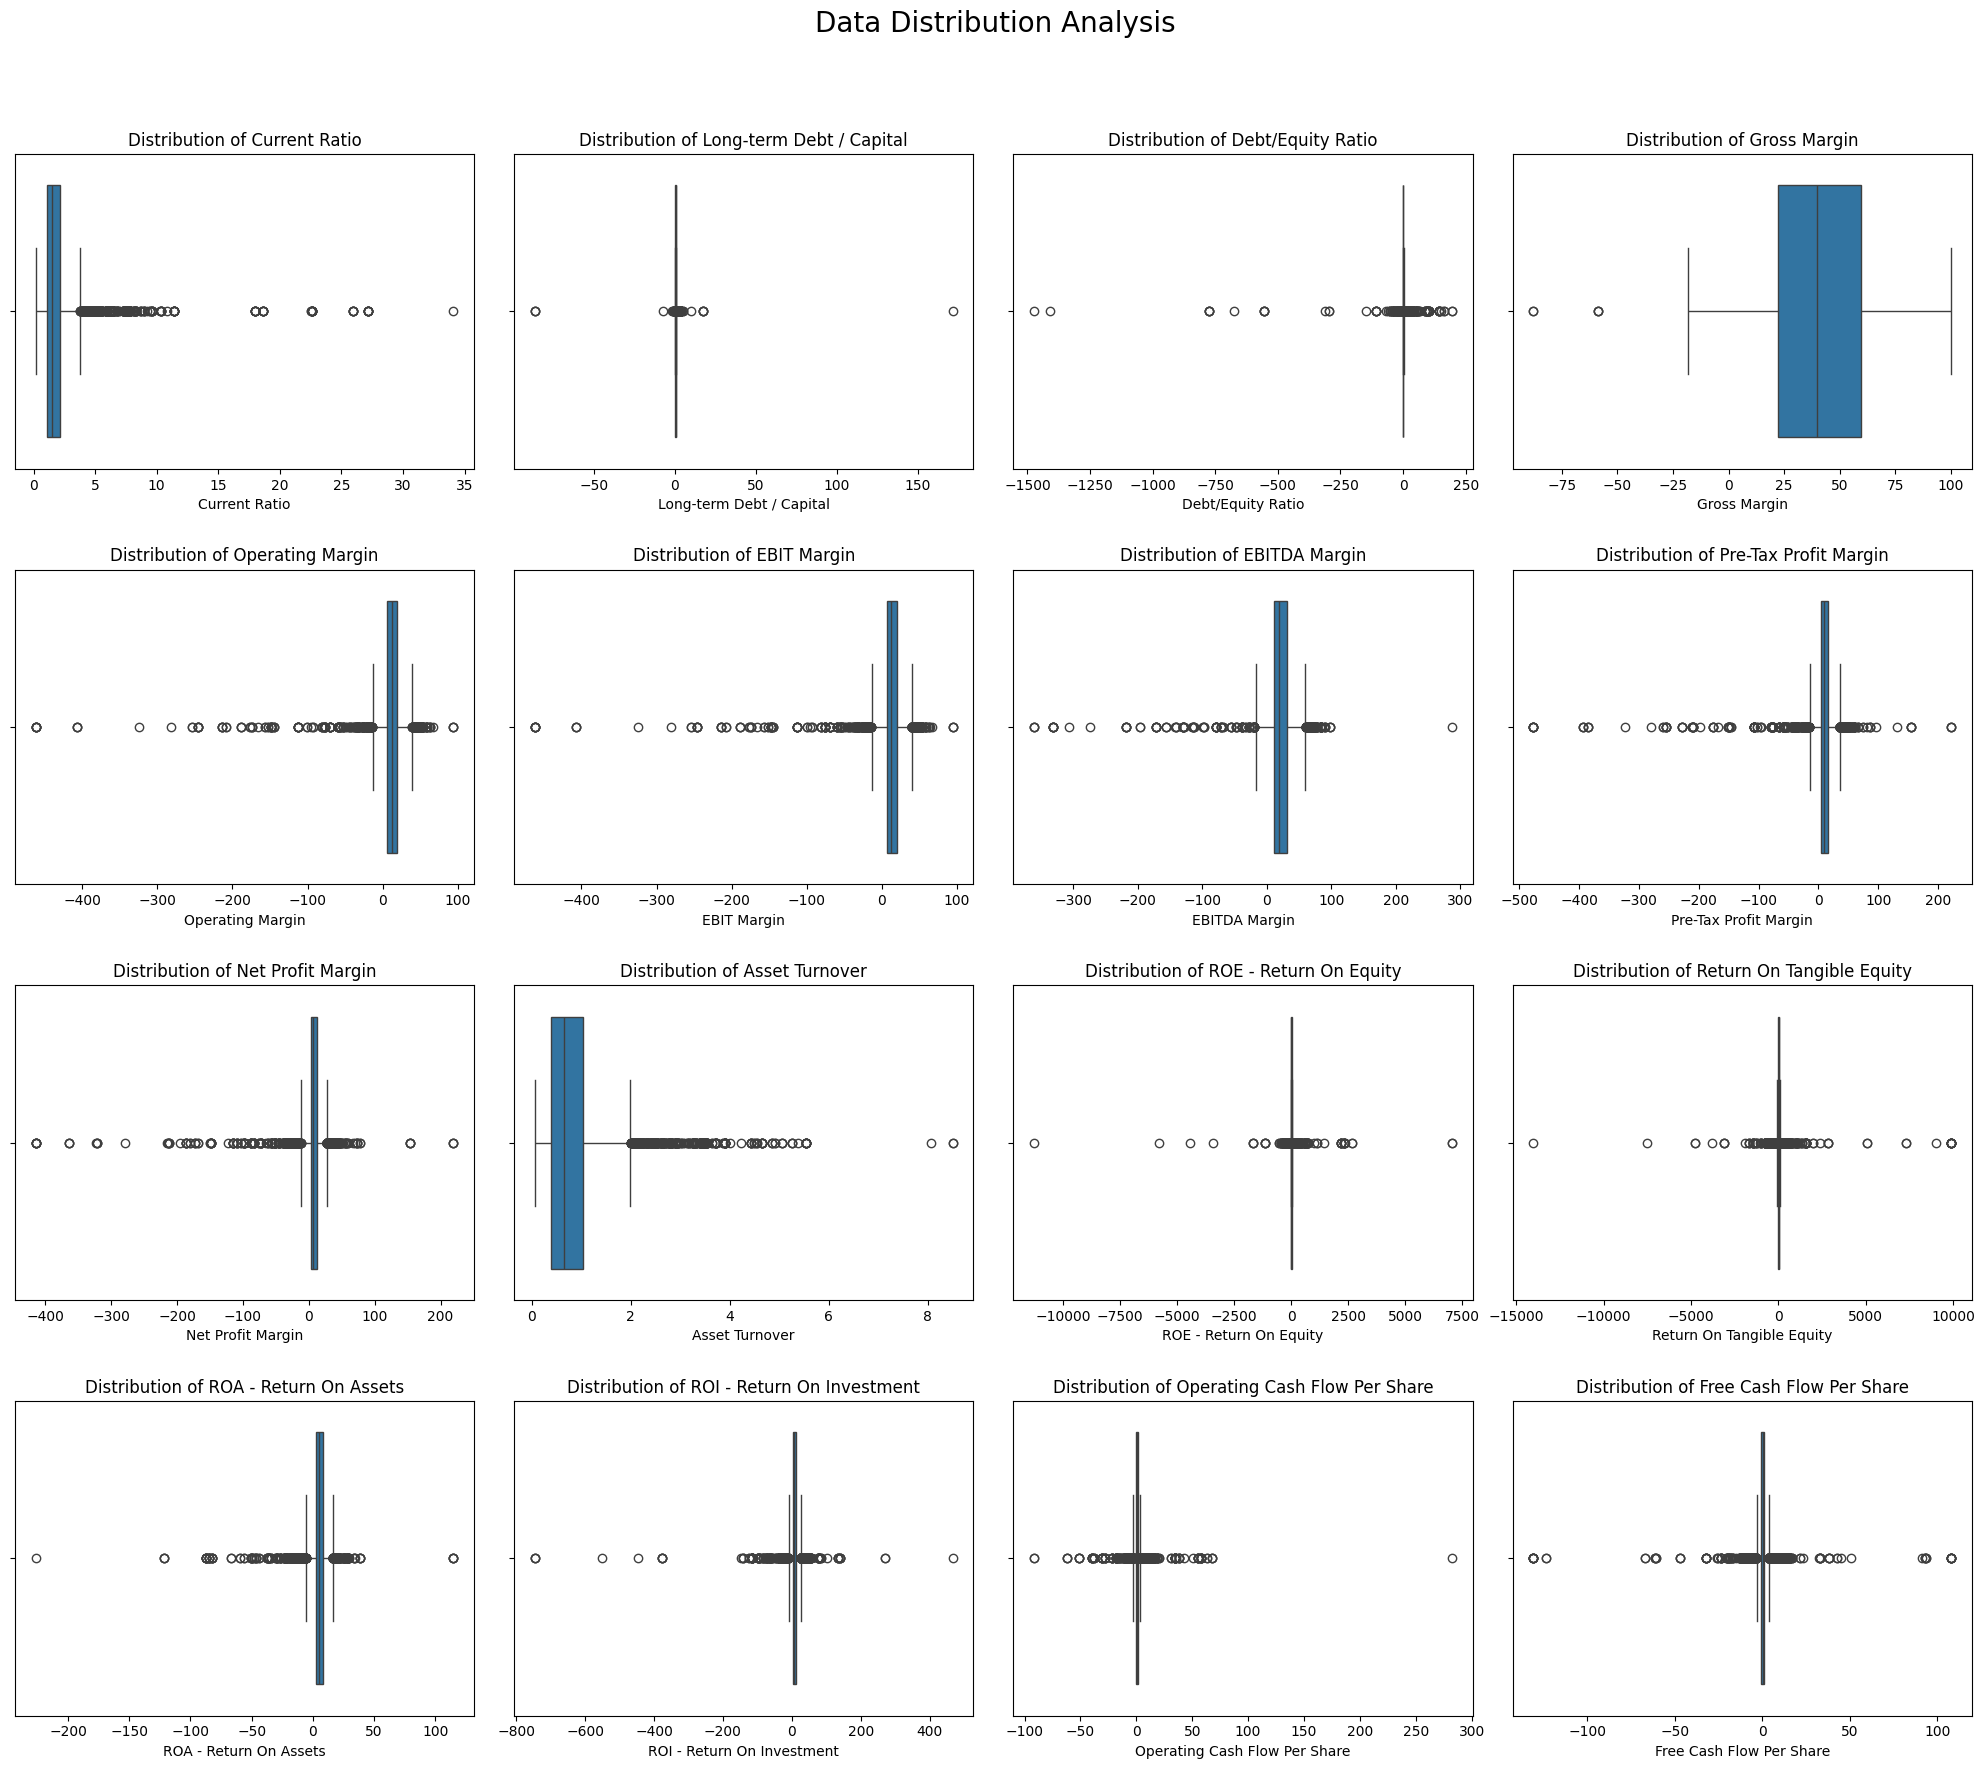

In [7]:
# Data Distribution Analysis using Boxplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 18))
axes = axes.flatten()

plt.suptitle('Data Distribution Analysis', fontsize=20)
i=0
for col in numerical_cols:
    # Histogram with KDE
    sns.boxplot(df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    i += 1
plt.tight_layout(h_pad=3.0)
plt.subplots_adjust(top=0.9)
plt.savefig('images/data_distribution_analysis_boxplot.png', bbox_inches='tight')

### 4.4. Outlier Analysis


Features with high outlier percentages (>10%):
                               Percentage
Return On Tangible Equity       15.080077
Debt/Equity Ratio               12.684177
ROE - Return On Equity          12.568866
Free Cash Flow Per Share        12.235746
Operating Cash Flow Per Share   11.479821


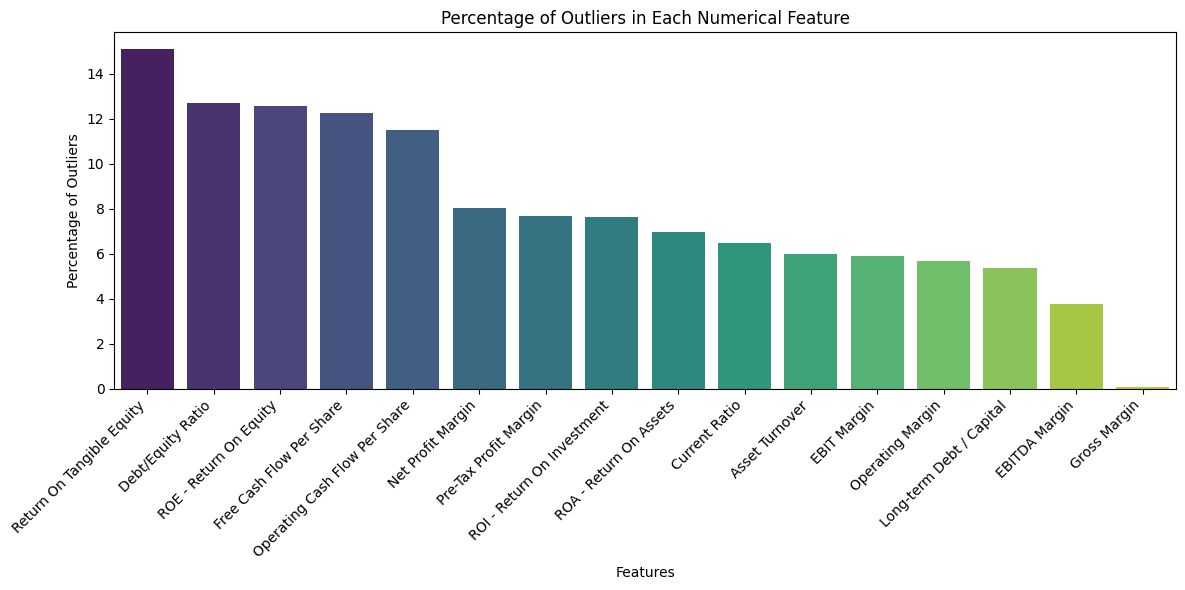

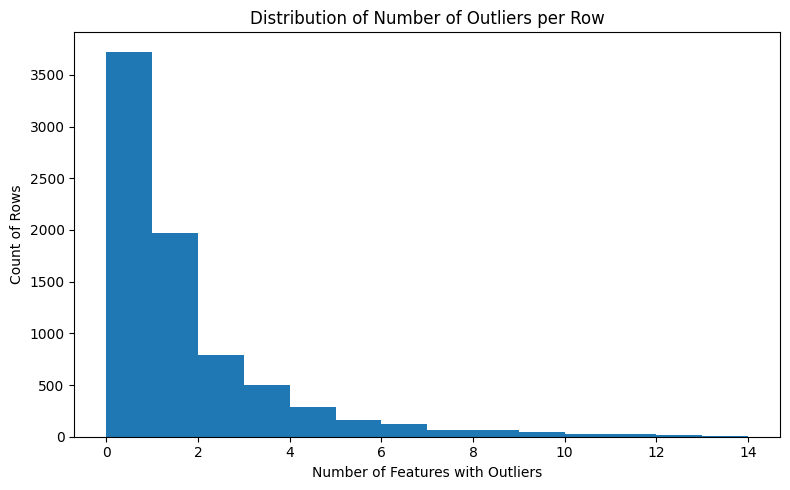

Total rows with outliers: 4079


In [8]:
# Outlier Detection using IQR method
def compute_outliers_percentage(df, columns):
    outlier_percents = {}
    outlier_masks = pd.DataFrame()
    for col in columns:
        # Calculate Q1, Q3 and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Calculate percentage of outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_percent = (len(outliers) / len(df)) * 100
        outlier_percents[col] = outlier_percent
        outlier_masks[col] = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    # Count outliers per row
    outlier_masks['Num_Outliers'] = outlier_masks.sum(axis=1) 
        
    return outlier_percents, outlier_masks

# Compute outlier percentages
outlier_percentages, outlier_masks = compute_outliers_percentage(df, numerical_cols)

# Create DataFrame for plotting
outlier_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Percentage'])
outlier_df = outlier_df.sort_values('Percentage', ascending=False)

# Display features with high outlier percentages (> 10%)
print("\nFeatures with high outlier percentages (>10%):")
print(outlier_df[outlier_df['Percentage'] > 10])

# Plot outlier percentages
plt.figure(figsize=(12, 6))
sns.barplot( data=outlier_df.reset_index(), x='index', y='Percentage', palette='viridis')
plt.title('Percentage of Outliers in Each Numerical Feature')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("images/outlier_percentages.png", bbox_inches='tight')
plt.show()

# Display distribution of number of outliers per row
plt.figure(figsize=(8, 5))
plt.hist(outlier_masks['Num_Outliers'], bins=range(outlier_masks['Num_Outliers'].max() + 2))
plt.title("Distribution of Number of Outliers per Row")
plt.xlabel("Number of Features with Outliers")
plt.ylabel("Count of Rows")
plt.tight_layout()
plt.savefig("images/outliers_per_row_distribution.png", bbox_inches='tight')
plt.show()


print(f"Total rows with outliers: {len(outlier_masks[outlier_masks['Num_Outliers'] > 0])}")


### 4.5. Correlation Analysis
Analyze the relationships between variables.

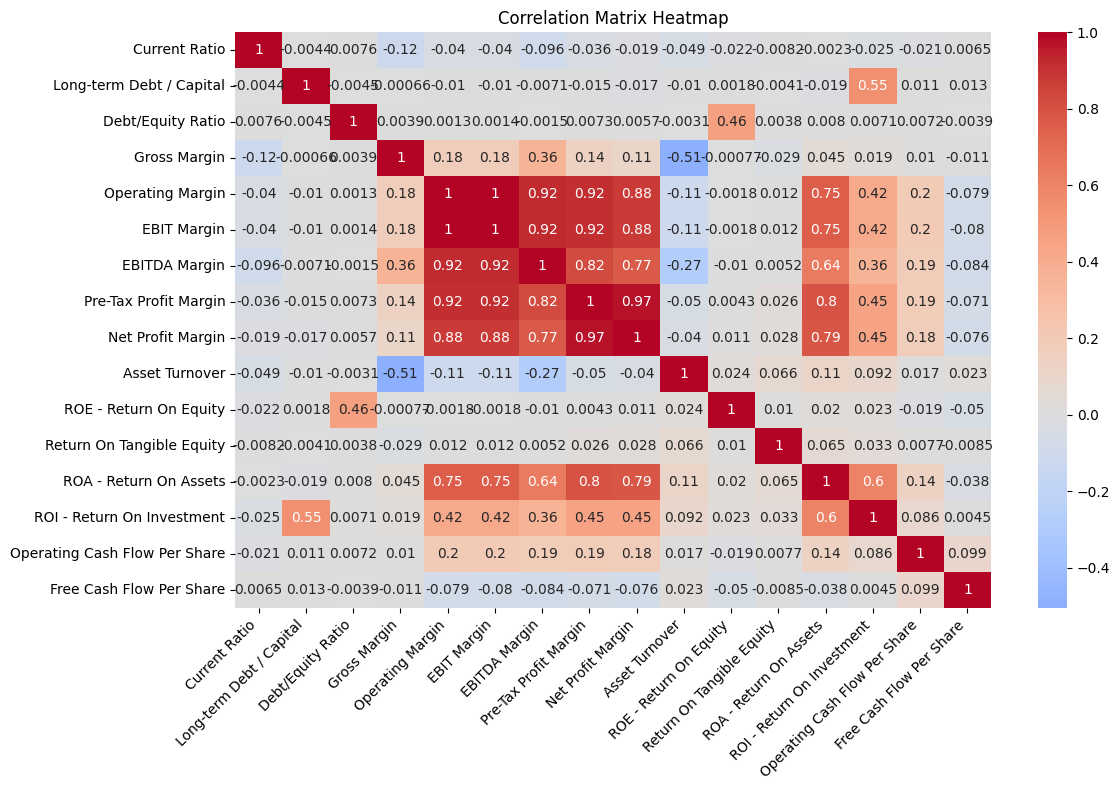

Highly correlated feature pairs (|corr| > 0.75):


,Feature 1,Feature 2,Correlation
0,Operating Margin,EBIT Margin,0.999700
11,Pre-Tax Profit Margin,Net Profit Margin,0.965150
5,EBIT Margin,EBITDA Margin,0.921193
1,Operating Margin,EBITDA Margin,0.920759
2,Operating Margin,Pre-Tax Profit Margin,0.916338
6,EBIT Margin,Pre-Tax Profit Margin,0.916165
3,Operating Margin,Net Profit Margin,0.879209
7,EBIT Margin,Net Profit Margin,0.879104
9,EBITDA Margin,Pre-Tax Profit Margin,0.819170
12,Pre-Tax Profit Margin,ROA - Return On Assets,0.797267


In [9]:
# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("images/correlation_heatmap.png", bbox_inches='tight')
plt.show()

# Create pair plots for highly correlated variables
# Find highly correlated pairs
high_corr = np.where(np.abs(corr_matrix) > 0.75)
print("Highly correlated feature pairs (|corr| > 0.75):")
corr_features = []
for i in range(len(high_corr[0])):
    if high_corr[0][i] != high_corr[1][i] and high_corr[0][i] < high_corr[1][i]:
        feat1 = numerical_cols[high_corr[0][i]]
        feat2 = numerical_cols[high_corr[1][i]] 
        corr_features.append([feat1, feat2, corr_matrix.iloc[high_corr[0][i], high_corr[1][i]]])
        #print(f"Pair: {feat1} and {feat2} with correlation {corr_matrix.iloc[high_corr[0][i], high_corr[1][i]]:.2f}")
high_corr_df = pd.DataFrame(corr_features, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)
display(high_corr_df)

## 5. Preprocess Data (Handle Missing Values, Encode Categoricals)

We handle missing values and encode categorical variables as needed for modeling.

In [10]:
# Drop columns not useful for modeling and keep only numerical features and target
drop_cols = ['Rating Agency', 'Corporation', 'Rating Date', 'CIK', 'Binary Rating', 'SIC Code', 'Sector', 'Ticker']
df_clean = df.drop(columns=drop_cols, errors='ignore')

# Encode categorical features (if any remain)
categorical_cols = df_clean.select_dtypes(include='object').columns.drop('Rating')
print("Categorical columns:", list(categorical_cols))
print(f"Total categorical columns to encode: {len(categorical_cols)}")

fig = px.histogram(df_clean, x="Rating", color="Rating", title="Distribution of Corporate Credit Ratings (Original)" )
fig.write_image("images/original_rating_distribution.png", width=1300, height=700)
fig.show()
# Group ratings into risk categories for more robust classification
rating_dict = {
'A' : 'Low Risk',
'A-' : 'Low Risk',
'A+' : 'Low Risk',
'AA' : 'Low Risk',
'AA-' : 'Low Risk',
'AA+' : 'Low Risk',
'AAA' : 'Lowest Risk',
'B' : 'High Risk',
'B-' : 'High Risk',
'B+' : 'High Risk',
'BB' : 'High Risk',
'BB-' : 'High Risk',
'BB+' : 'High Risk',
'BBB' : 'Medium Risk',
'BBB-' : 'Medium Risk',
'BBB+' : 'Medium Risk',
'C' : 'Highest Risk',
'CC' : 'Highest Risk',
'CC+' : 'Highest Risk',
'CCC' : 'Highest Risk',
'CCC-' : 'Highest Risk',
'CCC+' : 'Highest Risk',
'D' : 'Default'
}
df_clean['Rating'].replace(rating_dict, inplace=True)
print(df_clean['Rating'].value_counts())

fig = px.histogram(df_clean, x="Rating", color="Rating", title="Distribution of Corporate Credit Ratings (Grouped)")
fig.write_image("images/grouped_rating_distribution.png")
fig.show()


Categorical columns: []
Total categorical columns to encode: 0


Rating
Low Risk        2548
Medium Risk     2461
High Risk       2445
Highest Risk     256
Lowest Risk       90
Default            5
Name: count, dtype: int64


## 6. Train/Test Split

We split the data into training and test sets, stratifying on the target.

In [11]:
# Features: all except target columns
X = df_clean.drop(columns=['Rating'])
y = df_clean['Rating']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split( X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded )
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Classes: ['Default' 'High Risk' 'Highest Risk' 'Low Risk' 'Lowest Risk'
 'Medium Risk']
Train shape: (6244, 16), Test shape: (1561, 16)


## 7. Baseline Model with Logistic Regression

We train a Logistic Regression and evaluate its accuracy and classification report as a baseline.

In [12]:
# Use RobustScaler to handle outliers better
col_transformer = make_column_transformer((RobustScaler(), X.select_dtypes(include='number').columns), remainder='passthrough' )

# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', col_transformer),
    ('logreg', LogisticRegression())
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  Index(['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
       'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
       'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
       'ROE - Return On Equity', 'Return On Tangible Equity',
       'ROA - Return On Assets', 'ROI - Return On Investment',
       'Operating Cash Flow Per Share', 'Free Cash Flow Per Share'],
      dtype='object'))])),
                ('logreg', LogisticRegression())])

In [13]:
# Evaluate the model on training and test sets
train_score = pipeline.score(X_train, y_train)
print(f"Training Score: {train_score}")

test_score = pipeline.score(X_test, y_test)
print(f"Test Score: {test_score}")

params = pipeline.named_steps['logreg'].get_params()
print(f"Logistic Regression Parameters: {params}")

# Generate a classification report and confusion matrix
y_predTest = pipeline.predict(X_test)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_predTest, target_names=le.classes_))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_predTest))


Training Score: 0.5211402946828956
Test Score: 0.5272261370916079
Logistic Regression Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Classification Report (Test):
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
   High Risk       0.59      0.61      0.60       489
Highest Risk       0.67      0.08      0.14        51
    Low Risk       0.53      0.64      0.58       510
 Lowest Risk       0.00      0.00      0.00        18
 Medium Risk       0.45      0.39      0.42       492

    accuracy                           0.53      1561
   macro avg       0.37      0.29      0.29      1561
weighted avg       0.52      0.53      0.51      1561

Confusion Matrix (Test):
[[  0   1   0   0   

## 8. Train and Evaluate KNN, Logistic Regression, Decision Tree, SVM, Random Forest and Gradient Boosting Classifier

For each model, we create a pipeline, fit on training data, and evaluate accuracy, classification report, and confusion matrix on both train and test sets. We also record fit time.


KNN Results:
Train Accuracy: 0.7846, Test Accuracy: 0.6848, Fit Time: 0.00 sec
Classification Report (Test):
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
   High Risk       0.74      0.72      0.73       489
Highest Risk       0.55      0.33      0.41        51
    Low Risk       0.70      0.79      0.74       510
 Lowest Risk       0.45      0.28      0.34        18
 Medium Risk       0.62      0.60      0.61       492

    accuracy                           0.68      1561
   macro avg       0.51      0.45      0.47      1561
weighted avg       0.68      0.68      0.68      1561


Logistic Regression Results:
Train Accuracy: 0.5311, Test Accuracy: 0.5381, Fit Time: 6.14 sec
Classification Report (Test):
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
   High Risk       0.61      0.67      0.64       489
Highest Risk       0.67      0.08      0.14        51
    

,Train Time (s),Train Accuracy,Test Accuracy
Model,,,
KNN,0.004816,0.784593,0.684817
Logistic Regression,6.140875,0.531070,0.538117
Decision Tree,0.116222,0.888533,0.767457
SVM,2.301547,0.533152,0.530429
Random Forest,2.465441,0.888533,0.777066
Gradient Boosting Classifier,18.258287,0.761531,0.675208


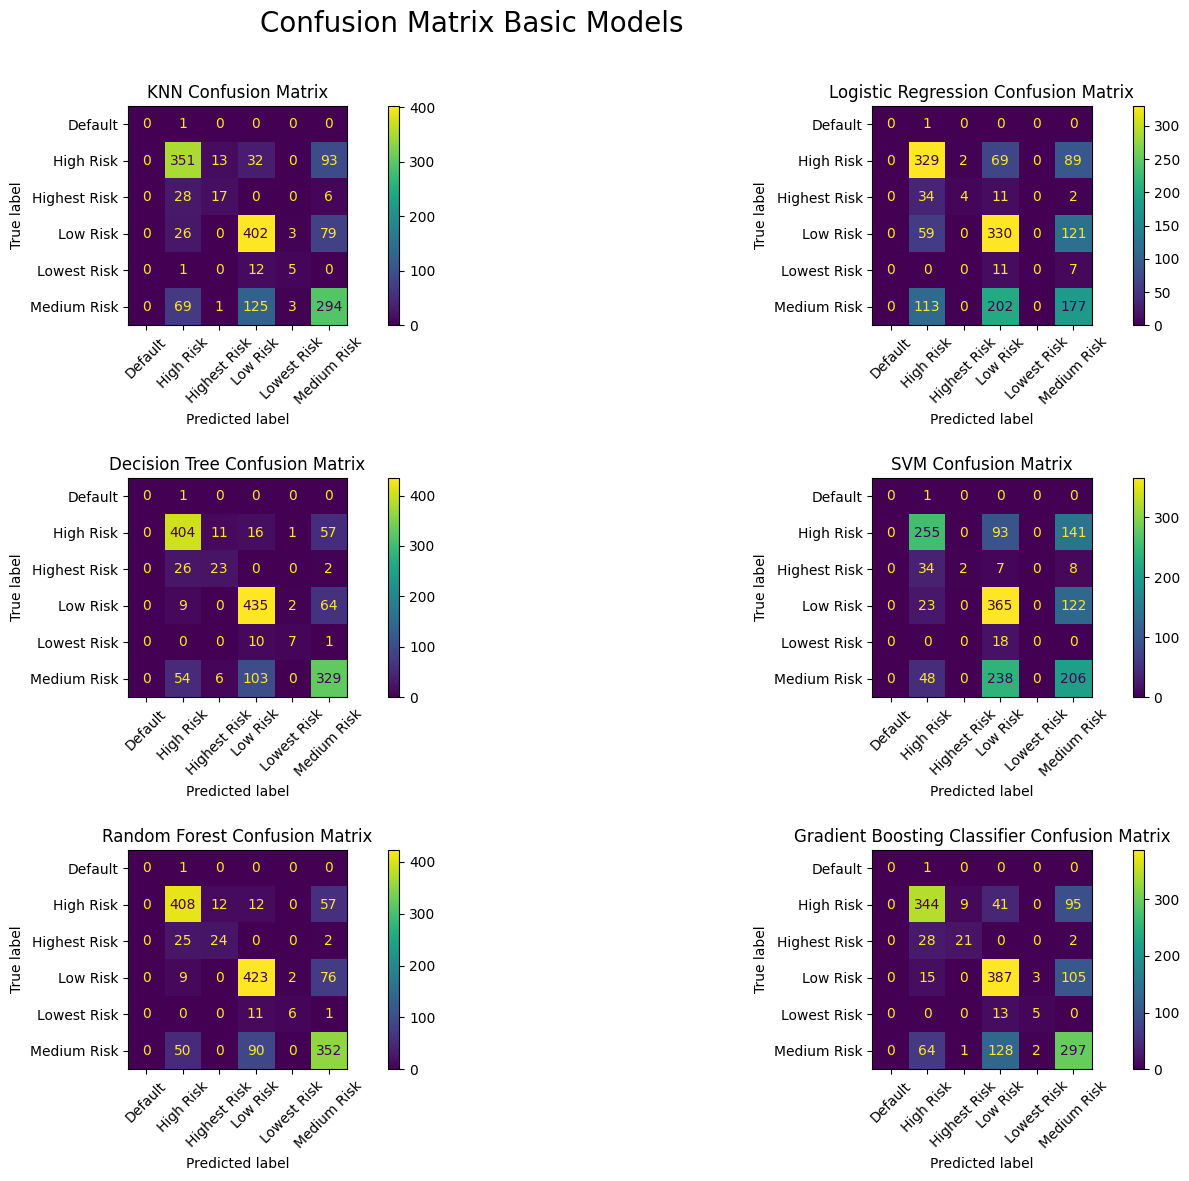

In [25]:
# Compare multiple models
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)   
}

results = []
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    pipe = Pipeline([
        ('preprocessor', col_transformer),
        ('classifier', model)
    ])
    start = time.time()
    pipe.fit(X_train, y_train)
    fit_time = time.time() - start

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"\n{name} Results:")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}, Fit Time: {fit_time:.2f} sec")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=axes[idx], xticks_rotation=45)
    axes[idx].set_title(f"{name} Confusion Matrix")

    results.append({
        'Model': name,
        'Train Time (s)': fit_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Pipeline': pipe
    })

results_df = pd.DataFrame([
    {
        'Model': r['Model'],
        'Train Time (s)': r['Train Time (s)'],
        'Train Accuracy': r['Train Accuracy'],
        'Test Accuracy': r['Test Accuracy']
    }
    for r in results
])
results_df.set_index('Model', inplace=True)
display(results_df)
plt.tight_layout(h_pad=3.0)
plt.subplots_adjust(top=0.9)
plt.suptitle('Confusion Matrix Basic Models', fontsize=20)
plt.savefig('images/confusion_matrix_basemodels.png', bbox_inches='tight')
plt.show()

## 8.1 Neural Networks

Neural Network Training Time: 37.29 seconds
0.6885009407997131
0.6591928005218506
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
   High Risk       0.76      0.70      0.73       489
Highest Risk       0.68      0.41      0.51        51
    Low Risk       0.68      0.76      0.72       510
 Lowest Risk       0.50      0.28      0.36        18
 Medium Risk       0.60      0.60      0.60       492

    accuracy                           0.68      1561
   macro avg       0.54      0.46      0.49      1561
weighted avg       0.68      0.68      0.67      1561



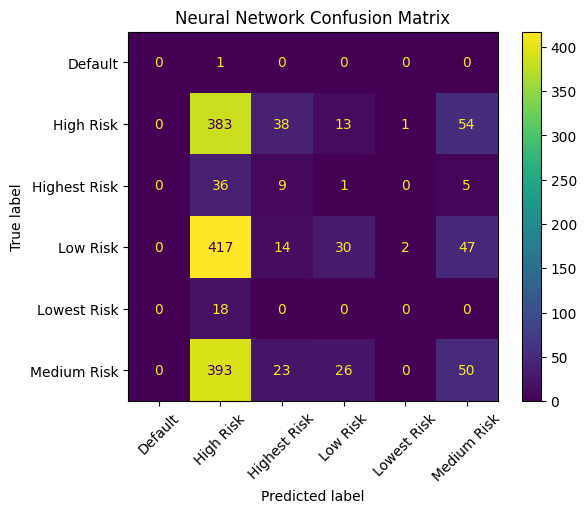

In [15]:
X_train_transformed = col_transformer.transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

stopper = EarlyStopping(monitor='val_recall',
    patience=5,         # Number of epochs to wait after last improvement
    restore_best_weights=True, # Keep the best performing weights
    mode='max'          # Specify that higher recall is better
    )

model = Sequential([Dense(100, activation = 'relu'),
                     Dropout(0.2),
                     Dense(100, activation = 'relu'),
                   Dense(6, activation = 'softmax')])

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
time_start = time.time()
history = model.fit(X_train_transformed, y_train, epochs = 100, batch_size=64, verbose = 0, validation_data=(X_test_transformed, y_test), callbacks = stopper)
time_end = time.time()
print(f"Neural Network Training Time: {time_end - time_start:.2f} seconds")
print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Neural Network Confusion Matrix")
plt.savefig('images/confusion_matrix_nn.png', bbox_inches='tight')
plt.show()

## 9. Hyperparameter Tuning with GridSearchCV

knn - Parameters: {'knn__n_neighbors': 3}

Classification Report (Test):
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
   High Risk       0.77      0.75      0.76       489
Highest Risk       0.49      0.39      0.43        51
    Low Risk       0.73      0.77      0.75       510
 Lowest Risk       0.50      0.28      0.36        18
 Medium Risk       0.66      0.66      0.66       492

    accuracy                           0.71      1561
   macro avg       0.52      0.48      0.49      1561
weighted avg       0.71      0.71      0.71      1561

logisticregression - Parameters: {'logisticregression__C': 1}

Classification Report (Test):
              precision    recall  f1-score   support

     Default       0.00      0.00      0.00         1
   High Risk       0.61      0.67      0.64       489
Highest Risk       0.67      0.08      0.14        51
    Low Risk       0.53      0.65      0.58       510
 Lowest Risk       0

,Train Time,Train Accuracy,Test Accuracy
Model,,,
knn,1.604711,0.828956,0.711723
logisticregression,10.832911,0.531070,0.538117
decisiontreeclassifier,0.210477,0.888533,0.767457
svc,6.674277,0.434978,0.440743
randomforestclassifier,4.066684,0.888533,0.782832
gradientboostingclassifier,115.566765,0.888533,0.778988


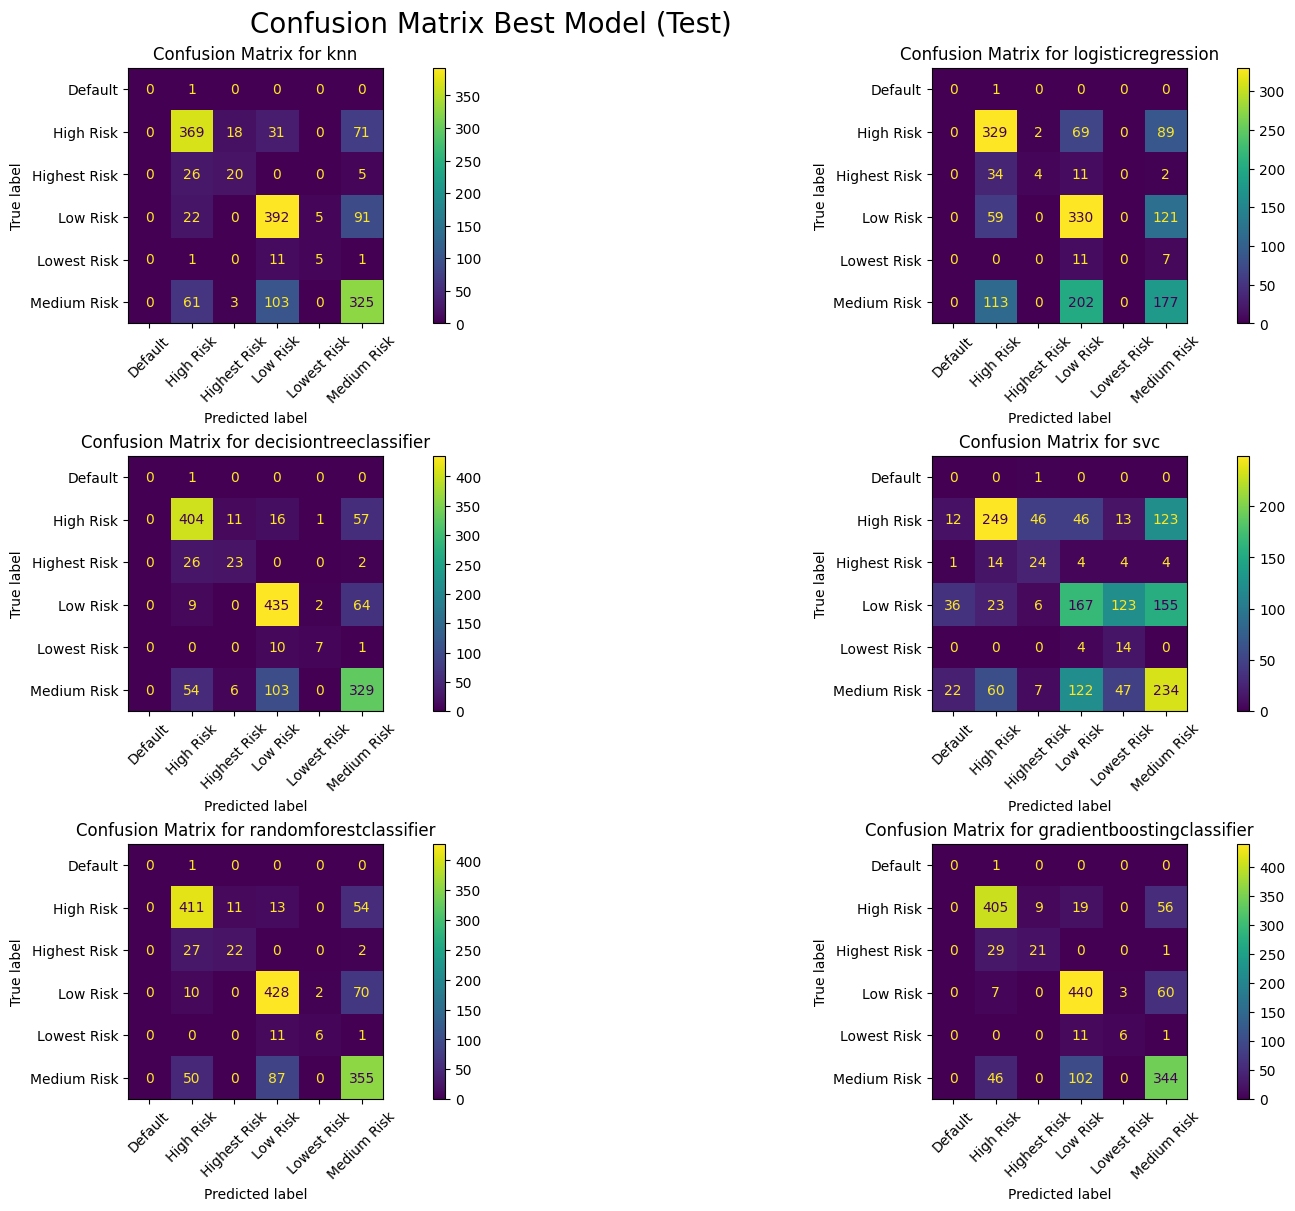

In [ ]:

models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7, 10]}),
    'logisticregression': (LogisticRegression(max_iter=10000, random_state=42), {'logisticregression__C': [0.01, 0.1, 1, 10, 15]}),
    'decisiontreeclassifier': (DecisionTreeClassifier(random_state=42), {'decisiontreeclassifier__max_depth': [5, 10, 15, None]}),
    'svc': (SVC(class_weight='balanced'), {'svc__C': [0.1, 1, 10, 15], 'svc__kernel': ['rbf']}), #unable to use 'linear' kernel due to computational limits,
    'randomforestclassifier': (RandomForestClassifier(random_state=42), {'randomforestclassifier__n_estimators': [50, 200], 'randomforestclassifier__max_depth': [5, 10, None]}),
    'gradientboostingclassifier': (GradientBoostingClassifier(random_state=42), {'gradientboostingclassifier__n_estimators': [50, 150], 'gradientboostingclassifier__learning_rate': [0.05, 0.2], 'gradientboostingclassifier__max_depth': [5, None]} )
}

bestModels ={}
results = []
fig, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
#fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()
i=0
for name, (model, params) in models.items():
    # Create a pipeline
    pipeline = Pipeline(steps=[
       ('preprocessor', col_transformer),
       (name, model)
    ])

    # Fit the model and time it
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])

    # Get the best estimator
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    bestModels[name] = best_model

    train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
    test_accuracy = accuracy_score(y_test, best_model.predict(X_test))

    print(f"{name} - Parameters: {best_params}")
    
    # Generate confusion matrix
    y_predTest = best_model.predict(X_test)

    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_predTest, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_predTest)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    ax = axes.flat[i]
    ax.set_title(f'Confusion Matrix for {name}')
    disp.plot(ax=ax, xticks_rotation=45)
    i += 1

    # Append the results
    results.append([name, fit_time, train_accuracy, test_accuracy])

plt.tight_layout(h_pad=3.0)
plt.subplots_adjust(top=0.9)
plt.suptitle('Confusion Matrix Best Model (Test)', fontsize=20)
plt.savefig('images/confusion_matrix_bestmodel.png', bbox_inches='tight')

# Create the results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
results_df.set_index('Model', inplace=True)

# Save to JSON
results_df.to_json('results/model_results_bestmodel.json')

results_df

## 10. Feature Importance Analysis for the Best Model

We extract and display feature importances or coefficients for the best-performing model to identify features with the highest impact on the rating.

Best Model: randomforestclassifier
Top 10 features by importance:


,Feature,Importance
1,Long-term Debt / Capital,0.086926
7,Pre-Tax Profit Margin,0.080333
0,Current Ratio,0.077237
13,ROI - Return On Investment,0.076373
8,Net Profit Margin,0.067793
3,Gross Margin,0.067668
2,Debt/Equity Ratio,0.066137
10,ROE - Return On Equity,0.060231
12,ROA - Return On Assets,0.059310
9,Asset Turnover,0.058616


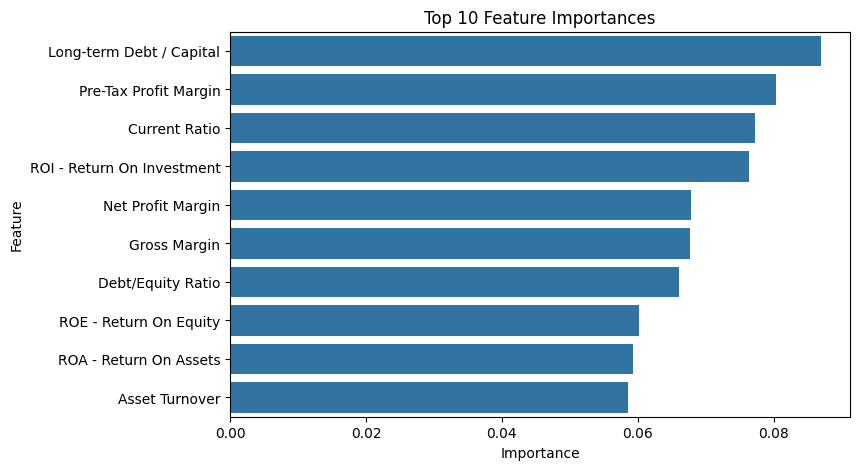

In [17]:
# Select the best model based on test accuracy
best_idx = results_df['Test Accuracy'].idxmax()
best_pipe = bestModels[best_idx]
#best_pipe = next(r['Pipeline'] for r in results if r['Model'] == best_idx)
print(f"Best Model: {best_idx}")

# Feature importance for Logistic Regression or Decision Tree
if best_idx == 'decisiontreeclassifier' or best_idx == 'randomforestclassifier' or best_idx == 'gradientboostingclassifier':
    feature_names = df_clean.columns.drop('Rating')
    importances = best_pipe.named_steps[best_idx].feature_importances_
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp = feat_imp.sort_values('Importance', ascending=False)
    print("Top 10 features by importance:")
    display(feat_imp.head(10))
    plt.figure(figsize=(8,5))
    sns.barplot(x='Importance', y='Feature', data=feat_imp.head(10))
    plt.title('Top 10 Feature Importances')
    plt.savefig('images/feature_importances_best_model.png', bbox_inches='tight')
    plt.show()
else:
    print("Feature importances are not directly available for this model.")